In [1]:
from tqdm import tqdm
import json
import pandas as pd
from pathlib import Path
import numpy as np

from bertopic import BERTopic
from sentence_transformers import SentenceTransformer
from bertopic.vectorizers import ClassTfidfTransformer
from bertopic.dimensionality import BaseDimensionalityReduction
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt  

2025-06-16 17:51:24.510969: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750085484.522213   32903 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750085484.525554   32903 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1750085484.535219   32903 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1750085484.535235   32903 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1750085484.535237   32903 computation_placer.cc:177] computation placer alr

In [2]:
split_dir = Path('dataset') / 'biobert_split'

In [3]:
X_train = np.load(split_dir / 'X_train.npy')
X_train_sent = np.load(split_dir / 'X_train_sent.npy')
X_test = np.load(split_dir / 'X_test.npy')
X_test_sent = np.load(split_dir / 'X_test_sent.npy')
y_train = np.load(split_dir / 'y_train.npy')
y_test = np.load(split_dir / 'y_test.npy')

len(X_train), len(X_test), len(y_train), len(y_test), len(X_train_sent), len(X_test_sent)

(338, 85, 338, 85, 338, 85)

In [4]:
X_train = [' '.join([w for w in row if w != '<PAD>']) for row in X_train]
X_test = [' '.join([w for w in row if w != '<PAD>']) for row in X_test]

X_train[0], X_test[0]

('em ##etophobia flying fly motion over the years husband 7 – 8 hour books 1 hour na husband regressed every day motion fly feel trapped',
 'intense emetophobia freaking out close boba tea stomach ache panic tired few hours later went to sleep woke up house ill fine eat stomach rumble almost 1 in the afternoon 30 minutes sick z ##ofran pep sick')

In [5]:
# sent_transformer = SentenceTransformer('allenai/scibert_scivocab_uncased')
sent_transformer = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')

In [6]:
X_train_sent_final = []
for row in X_train_sent:
    row = float(row)
    if row > 0.5:
        X_train_sent_final.append('positive')
    elif row < -0.5:
        X_train_sent_final.append('negative')
    else:
        X_train_sent_final.append('neutral')

X_test_sent_final = []
for row in X_test_sent:
    row = float(row)
    if row > 0.5:
        X_test_sent_final.append('positive')
    elif row < -0.5:
        X_test_sent_final.append('negative')
    else:
        X_test_sent_final.append('neutral')

X_train_sent_final[:5], X_test_sent_final[:5]

(['negative', 'negative', 'negative', 'negative', 'neutral'],
 ['negative', 'negative', 'neutral', 'negative', 'negative'])

In [7]:
X_train_final = []
for i in tqdm(range(len(X_train))):
    X_train_final.append(X_train[i] + ' ' + X_train_sent_final[i])

X_test_final = []
for i in tqdm(range(len(X_test))):
    X_test_final.append(X_test[i] + ' ' + X_test_sent_final[i])

X_train_final[:5], X_test_final[:5]

100%|██████████| 85/85 [00:00<00:00, 1246558.88it/s]


(['em ##etophobia flying fly motion over the years husband 7 – 8 hour books 1 hour na husband regressed every day motion fly feel trapped negative',
  'woke like 12am last night super throat body ache tu * scared d * stomach throat spray cough drop scared tu have an appetite everything hurts to eat negative',
  'anxiety time high anxiety physically upper chest fluttery feeling dia ##ragm panic attack heart attack chest left co ##rtisol adrenaline chest road trip 3 hours to breathe negative',
  'mom cart grandma healthy wednesday mind spiraling thoughts mom it kids nuts 2 yr old tu ##mmy hurt for a second anxiety negative',
  'it 3 bc brain painkillers left early weird fuzzy feeling cheeks bc scared ##ious spoiler 5 mins later gag it neutral'],
 ['intense emetophobia freaking out close boba tea stomach ache panic tired few hours later went to sleep woke up house ill fine eat stomach rumble almost 1 in the afternoon 30 minutes sick z ##ofran pep sick negative',
  'of stupidity ate 3 / 4 

In [8]:
n_clusters = len(['Question', 'Needing support - Panic attack', 'Rant', 'Potentially Triggering', 'Does Anyone Else...?', 'Needing support: Just not feeling good'])

In [9]:
labels_mapping = {
    "Question": 0,
    "Needing support - Panic attack": 1,
    "Rant": 2,
    "Potentially Triggering": 3,
    "Does Anyone Else...?": 4,
    "Needing support: Just not feeling good": 5
}

y_train_final = [labels_mapping[y] for y in y_train]
y_test_final = [labels_mapping[y] for y in y_test]

In [10]:
empty_dim_model = BaseDimensionalityReduction()
clf = SVC(kernel='rbf', probability=True, random_state=42)
ctfidf_model = ClassTfidfTransformer()

topic_model = BERTopic(
    umap_model= empty_dim_model,
    hdbscan_model=clf,
    ctfidf_model=ctfidf_model,
    verbose=True,
    calculate_probabilities=True,
    embedding_model=sent_transformer
)

In [11]:
y_train_final = np.array(y_train_final)
y_test_final = np.array(y_test_final)

In [12]:
topics, probs = topic_model.fit_transform(X_train_final, y=y_train_final)



2025-06-16 17:51:32,807 - BERTopic - Embedding - Transforming documents to embeddings.


Batches:   0%|          | 0/11 [00:00<?, ?it/s]

2025-06-16 17:51:33,120 - BERTopic - Embedding - Completed ✓
2025-06-16 17:51:33,121 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-06-16 17:51:33,122 - BERTopic - Dimensionality - Completed ✓
2025-06-16 17:51:33,122 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-06-16 17:51:33,197 - BERTopic - Cluster - Completed ✓
2025-06-16 17:51:33,200 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-06-16 17:51:33,211 - BERTopic - Representation - Completed ✓


In [13]:
topics_test, probs_test = topic_model.transform(X_test_final)

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

2025-06-16 17:51:33,268 - BERTopic - Dimensionality - Reducing dimensionality of input embeddings.
2025-06-16 17:51:33,268 - BERTopic - Dimensionality - Completed ✓
2025-06-16 17:51:33,268 - BERTopic - Clustering - Approximating new points with `hdbscan_model`
2025-06-16 17:51:33,273 - BERTopic - Cluster - Completed ✓


In [14]:
acc = accuracy_score(y_test_final, topics_test)
f1 = f1_score(y_test_final, topics_test, average='weighted')
precision = precision_score(y_test_final, topics_test, average='weighted')
recall = recall_score(y_test_final, topics_test, average='weighted')
print(f"Accuracy: {acc:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")


Accuracy: 0.0941
F1 Score: 0.0605
Precision: 0.0633
Recall: 0.0941


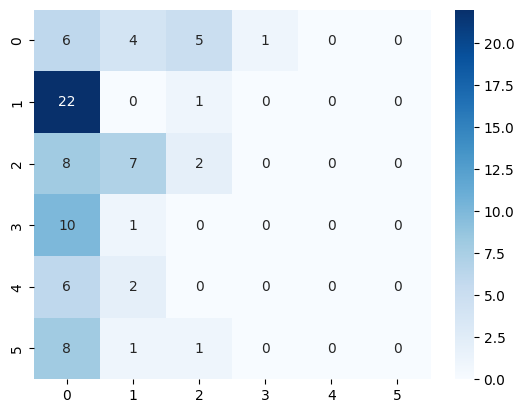

In [15]:
ax = sns.heatmap(confusion_matrix(y_test_final, topics_test), annot=True, fmt='d', cmap='Blues')